In [15]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load all 4 datasheets
account_balance = pd.read_csv('../data/current_account_balance_billionsUSD.csv')
gov_debt = pd.read_csv('../data/government_gross_debt.csv')
inflation = pd.read_csv('../data/inflation_rate.csv')
gdp_growth = pd.read_csv('../data/real_gdp_growth.csv')

# Global Economic Intelligence: Regional Performance Analysis & Interconnectedness Mapping

**Strategic Framework**: This comprehensive analysis examines global economic health through multi-dimensional regional and country-level assessments, utilizing four critical macroeconomic indicators to reveal performance patterns, economic interconnectedness, and development trajectories. We investigate: (1) regional GDP growth dynamics revealing economic momentum across global regions, (2) top-performing countries identifying economic success stories, (3) correlation analysis uncovering relationships between key economic variables, and (4) multi-dimensional visualization revealing complex economic interdependencies that shape global development patterns and policy implications.

In [17]:
# turn the whole process into a function for all datasets. 
def clean_account_data(df):
    # define regions to separate country and region dataset
    region_names = [
        "Africa (Region)", "Asia and Pacific", "Australia and New Zealand", "Caribbean",
        "Central America", "Central Asia and the Caucasus", "East Asia", "Eastern Europe",
        "Europe", "Middle East (Region)", "North Africa", "North America", "Pacific Islands",
        "South America", "South Asia", "Southeast Asia", "Sub-Saharan Africa (Region)",
        "Western Europe", "Western Hemisphere (Region)", "ASEAN-5", "Advanced economies",
        "Emerging and Developing Asia", "Emerging and Developing Europe",
        "Emerging market and developing economies", "Euro area", "European Union",
        "Latin America and the Caribbean", "Major advanced economies (G7)",
        "Middle East and Central Asia", "Other advanced economies", "Sub-Saharan Africa", "World"
    ]
    
    df = df.iloc[1:-2].copy()  # drop first row (extra header) and last two rows (footnotes)
    df.rename(columns={df.columns[0]: "country"}, inplace=True)
    df['country'] = df['country'].str.lower()
    df.replace('no data', np.nan, inplace=True)
    
    # ensure values are all numeric, orginally stored as an object. 
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # strip spaces
    df['country'] = df['country'].str.strip()

    # separate country and region dataset
    countries_df = df[~df['country'].isin([r.lower() for r in region_names])].copy()
    regions_df = df[df['country'].isin([r.lower() for r in region_names])].copy()
    
    return countries_df, regions_df


In [18]:
account_countries, account_regions = clean_account_data(account_balance)
debt_countries, debt_regions = clean_account_data(gov_debt)
inflation_countries, inflation_regions = clean_account_data(inflation)
gdp_countries, gdp_regions = clean_account_data(gdp_growth)


In [58]:
# check it works
account_countries.sample(6)

# it does !

,country,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
31,cambodia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-10.886,-7.572,0.555,-0.801,1.126,0.561,-0.357,-0.386,-0.265,-0.150
106,malaysia,-0.266,-2.469,-3.585,-3.482,-1.657,-0.600,-0.101,2.575,1.867,...,14.524,13.002,6.184,7.132,7.310,8.444,9.853,10.683,11.583,12.329
86,japan,-10.750,4.761,6.847,20.804,35.009,50.180,84.522,84.253,79.173,...,196.206,89.851,158.505,192.968,141.908,144.736,151.093,156.444,155.484,151.445
171,tajikistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.736,1.635,0.584,0.635,0.128,-0.335,-0.364,-0.407,-0.449,-0.497
186,united states,2.316,5.031,-5.533,-38.695,-94.342,-118.159,-147.176,-160.661,-121.159,...,-867.980,-1012.098,-905.376,-1133.621,-1137.718,-1006.465,-1003.134,-900.787,-910.658,-893.665
114,"micronesia, fed. states of",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009,0.037,0.016,-0.002,-0.007,-0.021,-0.021,-0.023,-0.027,-0.030


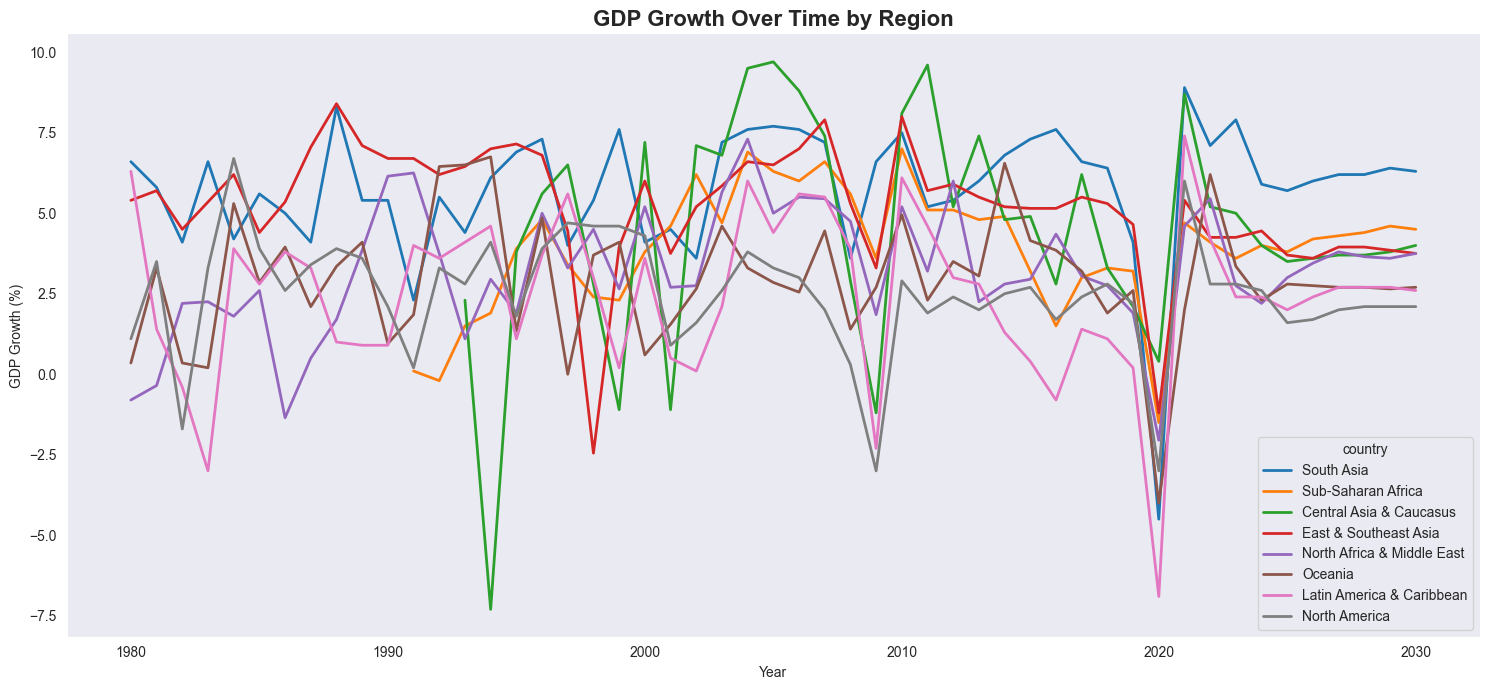

In [41]:
# nominate regions to cover the gloval without double-dipping
# Dictionary mapping messy names to clean names
region_rename = {
    "north america": "North America",
    "latin america and the caribbean": "Latin America & Caribbean",
    "sub-saharan africa": "Sub-Saharan Africa",
    "north africa": "North Africa & Middle East",
    "middle east (region)": "North Africa & Middle East",
    "central asia and the caucasus": "Central Asia & Caucasus",
    "south asia": "South Asia",
    "east asia": "East & Southeast Asia",
    "southeast asia": "East & Southeast Asia",
    "australia and new zealand": "Oceania",
    "pacific islands": "Oceania"
}

gdp_adjusted = gdp_regions.copy()
gdp_adjusted['country'] = gdp_adjusted['country'].str.lower().replace(region_rename)

# Step 3 – Keep only the final clean regions
final_regions = [
    "North America",
    "Latin America & Caribbean",
    "Sub-Saharan Africa",
    "North Africa & Middle East",
    "Central Asia & Caucasus",
    "South Asia",
    "East & Southeast Asia",
    "Oceania"
]

# Make lowercase for matching, then replace, then titlecase if wanted
gdp_adjusted = gdp_adjusted[gdp_adjusted['country'].isin(final_regions)]

# combine regions
gdp_adjusted = gdp_adjusted.groupby('country', as_index=False).mean()

# --- Reshape to long format ---
df_long = gdp_adjusted.melt(id_vars=['country'], var_name='year', value_name='gdp_growth')
df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')

last_year = df_long['year'].max()
order = (
    df_long[df_long['year'] == last_year]
    .sort_values('gdp_growth', ascending=False)['country']
    .tolist()
)

# --- Plot with Seaborn ---
sns.set_style("dark")
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=df_long, 
    x='year', 
    y='gdp_growth', 
    hue='country',
    hue_order=order,
    linewidth=2
)


plt.title("GDP Growth Over Time by Region", fontsize=16, weight='bold')
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
sns.despine()
plt.tight_layout()
plt.show()

## Regional Economic Momentum: Global Growth Trajectory Analysis

**Geographic Economic Mapping**: Implementing sophisticated regional aggregation to capture macro-level economic trends across major global regions while avoiding double-counting and overlapping classifications. This analysis transforms fragmented country-level data into coherent regional narratives, revealing which parts of the world are experiencing sustained economic expansion versus those facing growth challenges.

**Strategic Regional Framework**: The analysis focuses on eight distinct economic regions representing different development models, resource endowments, and policy approaches. This regional lens enables identification of successful development strategies, economic integration benefits, and geographic factors influencing growth trajectories. Understanding regional performance patterns provides insights into global economic rebalancing, emerging market dynamics, and the effectiveness of different economic policy frameworks across diverse geographic and cultural contexts.

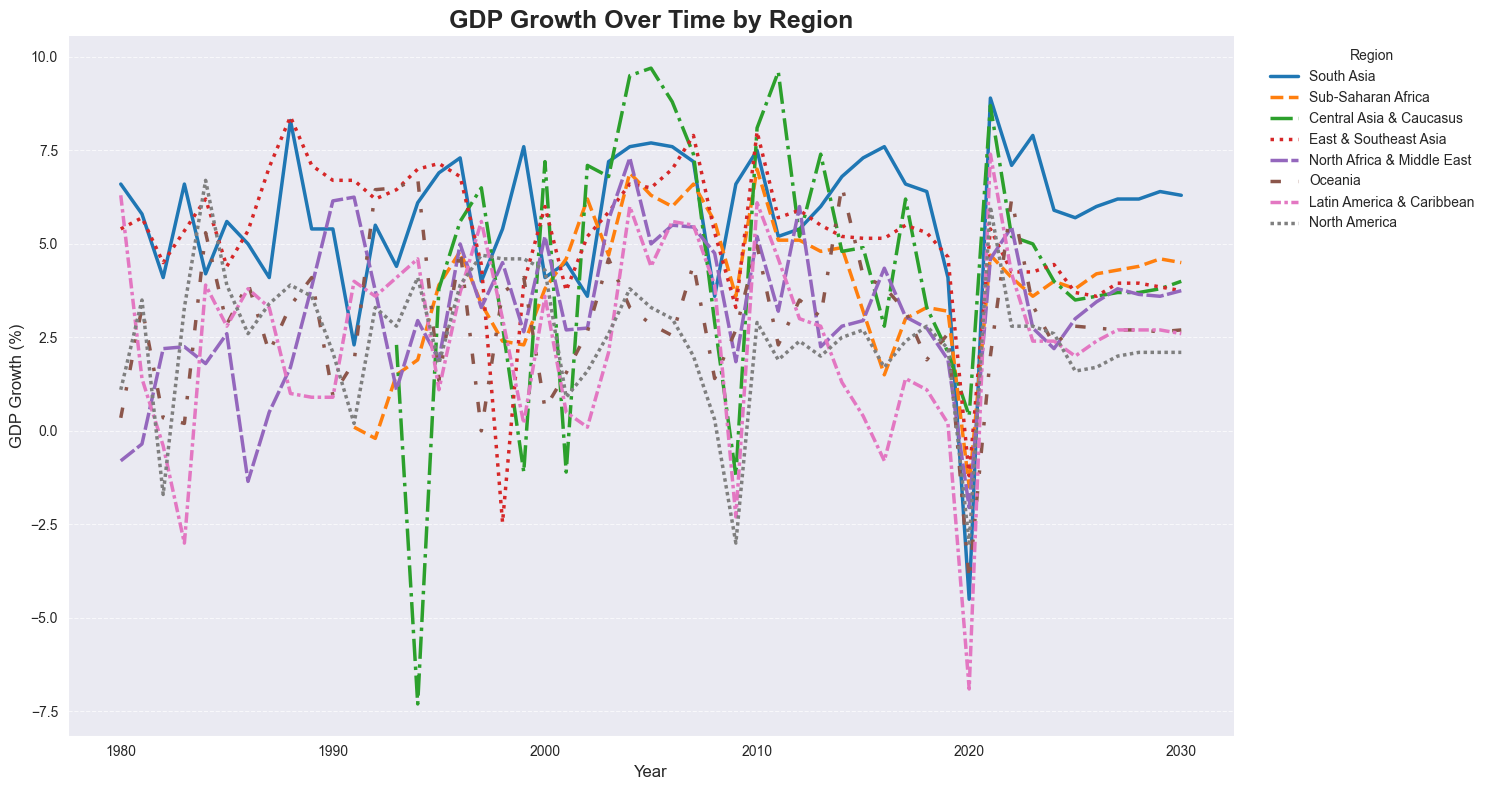

In [43]:
# Define a custom linestyle mapping
linestyles = {
    "South Asia": "solid",
    "Sub-Saharan Africa": "dashed",
    "Central Asia & Caucasus": "dashdot",
    "East & Southeast Asia": "dotted",
    "North Africa & Middle East": (0, (5, 1)),  # custom dash pattern
    "Oceania": (0, (3, 5, 1, 5)),               # dot-dash
    "Latin America & Caribbean": (0, (3, 1, 1, 1)),
    "North America": (0, (1, 1)),               # very fine dots
}

plt.figure(figsize=(15, 8))
palette = sns.color_palette("tab10", n_colors=len(linestyles))

# Plot each region separately to control linestyle
for (region, style), color in zip(linestyles.items(), palette):
    region_data = df_long[df_long['country'] == region]
    plt.plot(
        region_data['year'],
        region_data['gdp_growth'],
        label=region,
        linestyle=style,
        color=color,
        linewidth=2.5
    )

plt.title("GDP Growth Over Time by Region", fontsize=18, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("GDP Growth (%)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Region', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
sns.despine()
plt.tight_layout()
plt.show()


## Advanced Visualization: Multi-Pattern Economic Differentiation

**Visual Analytics Enhancement**: Implementing sophisticated line style differentiation to overcome color-blind accessibility limitations while enabling clear distinction between regional economic trajectories. This advanced visualization approach ensures analytical inclusivity while maximizing information density and pattern recognition capabilities across diverse audiences.

**Pattern Recognition Strategy**: Each region receives unique visual encoding through custom line styles, enabling simultaneous comparison of eight different economic development patterns. This methodology reveals temporal dynamics, volatility patterns, and trend convergence/divergence that might be obscured in traditional single-style visualizations. The approach facilitates identification of economic cycles, crisis impacts, and recovery patterns across different regional contexts, supporting more nuanced economic policy analysis and international development strategy formulation.

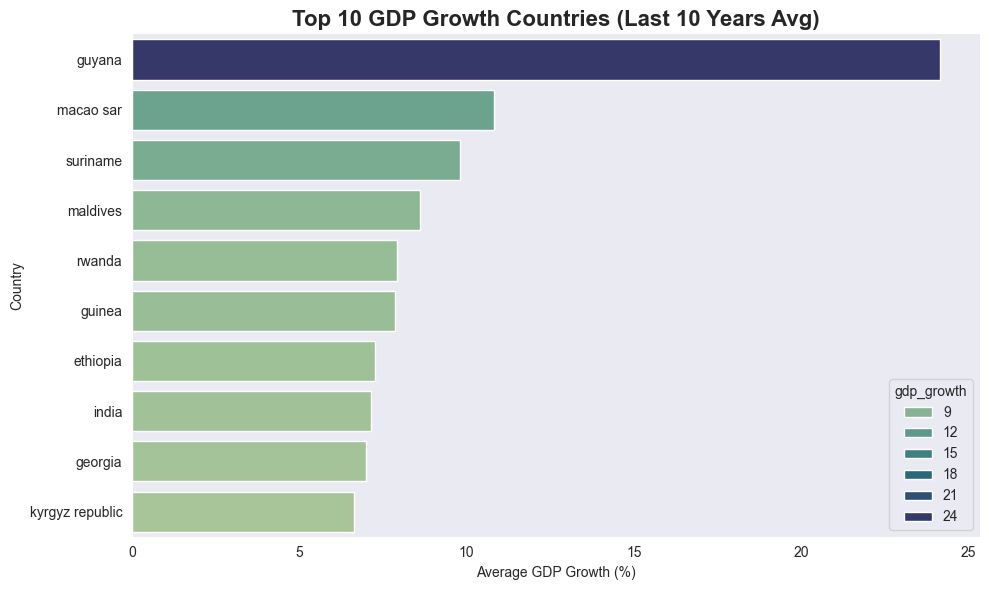

In [51]:
# --- Reshape country-level data ---
df_c_long = gdp_countries.melt(id_vars=['country'], var_name='year', value_name='gdp_growth')
df_c_long['year'] = pd.to_numeric(df_c_long['year'], errors='coerce')

# --- Filter last 10 years ---
last_10_years = range(df_c_long['year'].max() - 9, df_c_long['year'].max() + 1)
df_last10 = df_c_long[df_c_long['year'].isin(last_10_years)]

# --- Average growth by country ---
avg_growth_countries = (
    df_last10.groupby('country', as_index=False)['gdp_growth']
    .mean()
    .sort_values('gdp_growth', ascending=False)
)

# --- Select top 10 ---
top_10_countries = avg_growth_countries.head(10)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_countries, 
    x='gdp_growth', 
    y='country', 
    palette='crest', 
    hue='gdp_growth',
)

plt.title("Top 10 GDP Growth Countries (Last 10 Years Avg)", fontsize=16, weight='bold')
plt.xlabel("Average GDP Growth (%)")
plt.ylabel("Country")
sns.despine()
plt.tight_layout()
plt.show()


## Economic Champions: Identifying Global Growth Leaders

**High-Performance Country Analysis**: Transitioning from regional aggregates to granular country-level examination to identify specific nations demonstrating exceptional economic performance over sustained periods. This analysis reveals which countries have successfully implemented growth strategies that deliver consistent results, providing valuable case studies for economic development policy and international best practices.

**Temporal Averaging Methodology**: Implementing 10-year averaging to smooth cyclical volatility and identify genuine structural economic strength rather than temporary growth spurts or commodity price windfalls. This approach distinguishes between countries with sustainable development models versus those experiencing short-term booms. The ranking methodology emphasizes consistency and resilience, highlighting economies that maintain strong performance through various global economic conditions and external shocks.

In [60]:
def reshape_df(df, value_name):
    df_long = df.melt(id_vars=['country'], var_name='year', value_name=value_name)
    df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
    return df_long

gdp_long = reshape_df(gdp_countries, 'gdp_growth')
debt_long = reshape_df(debt_countries, 'gov_debt')
infl_long = reshape_df(inflation_countries, 'inflation')
acct_long = reshape_df(account_countries, 'account_balance')

## Economic Interconnectedness: Correlation Analysis & Dependency Mapping

**Correlation Matrix Interpretation**: The correlation heatmap reveals critical relationships between macroeconomic indicators that inform policy design and economic forecasting. Strong correlations between certain metrics suggest shared underlying drivers or causal relationships, while weak correlations indicate independent policy levers. This analysis is essential for understanding which economic indicators move together and which can be targeted independently for policy intervention.

**Multicollinearity Assessment**: Examining correlation patterns to identify redundant indicators and optimize analytical frameworks. High correlations between variables (>0.7) suggest potential multicollinearity issues that could complicate regression analyses, while negative correlations reveal trade-offs inherent in economic policy choices. Understanding these relationships enables more sophisticated economic modeling and helps policymakers anticipate second-order effects of their interventions.

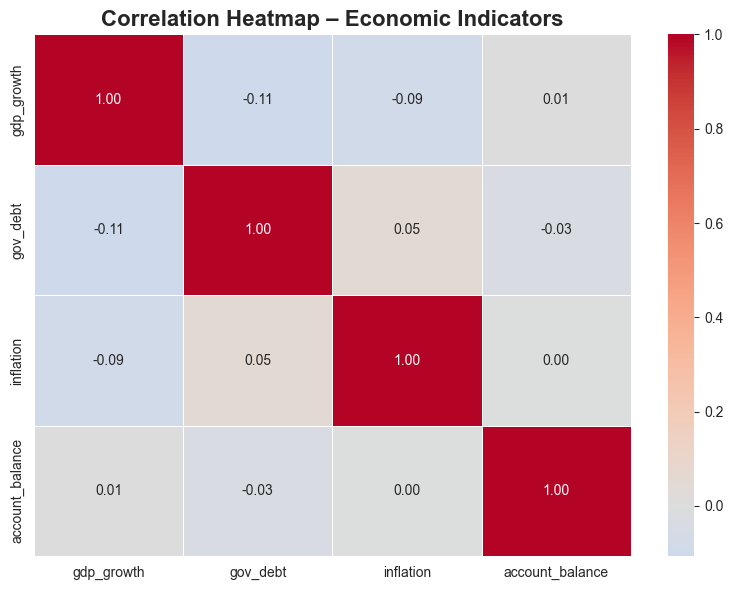

In [63]:
from functools import reduce

dfs = [gdp_long, debt_long, infl_long, acct_long]
mega_df = reduce(lambda left, right: pd.merge(left, right, on=['country', 'year'], how='inner'), dfs)


# --- 1. Compute correlations ---
corr_matrix = mega_df[['gdp_growth', 'gov_debt', 'inflation', 'account_balance']].corr()

# --- 2. Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,           # show correlation values
    fmt=".2f",             # 2 decimal places
    cmap="coolwarm",       # colour scheme
    center=0,              # 0 correlation is white
    linewidths=0.5
)

plt.title("Correlation Heatmap – Economic Indicators", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


In [64]:
def reshape_region(df, value_name):
    df_long = df.melt(id_vars=['country'], var_name='year', value_name=value_name)
    df_long['year'] = pd.to_numeric(df_long['year'], errors='coerce')
    return df_long

gdp_r_long   = reshape_region(gdp_regions, 'gdp_growth')
debt_r_long  = reshape_region(debt_regions, 'gov_debt')
infl_r_long  = reshape_region(inflation_regions, 'inflation')
acct_r_long  = reshape_region(account_regions, 'account_balance')


In [66]:
from functools import reduce

dfs_regions = [gdp_r_long, debt_r_long, infl_r_long, acct_r_long]
mega_regions = reduce(lambda left, right: pd.merge(left, right, on=['country', 'year'], how='inner'), dfs_regions)

# Group by region and average across all years
region_avg = mega_regions.groupby('country', as_index=False)[['gdp_growth', 'gov_debt', 'inflation', 'account_balance']].mean()

# Correlation matrix
corr_matrix_regions = region_avg[['gdp_growth', 'gov_debt', 'inflation', 'account_balance']].corr()


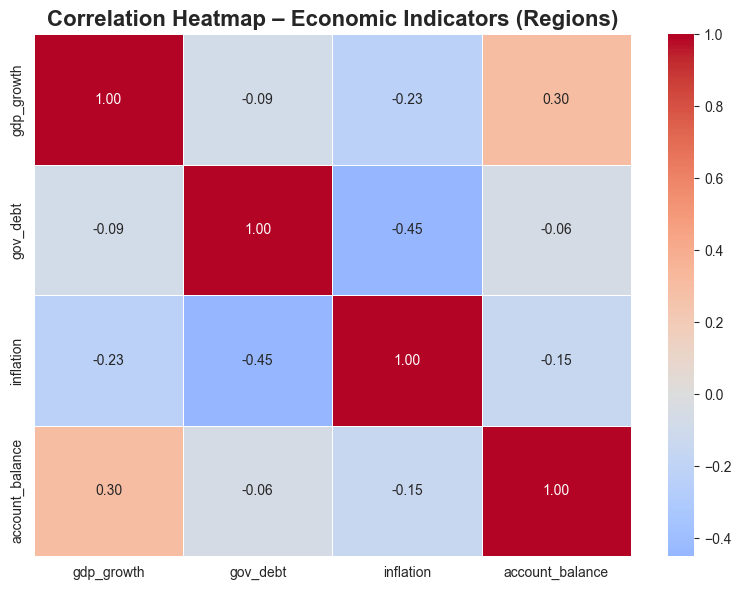

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix_regions,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap – Economic Indicators (Regions)", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


## Regional Economic Dynamics: Comparative Performance & Strategic Positioning

**Cross-Regional Analysis Framework**: Regional correlation analysis reveals how different geographic areas respond to similar economic pressures and whether regional integration creates synchronized economic cycles. Strong correlations between regions suggest shared vulnerabilities or interconnected trade relationships, while divergent patterns indicate independent growth trajectories that could provide diversification benefits for global portfolios and policy coordination.

**Geographic Economic Intelligence**: Understanding regional correlation patterns enables strategic decision-making for international investment, trade policy, and crisis response coordination. Regions with low correlations to global patterns may offer unique economic opportunities or serve as hedges against worldwide downturns. This analysis supports both risk management strategies and identification of emerging growth poles that could reshape global economic geography in the coming decades.

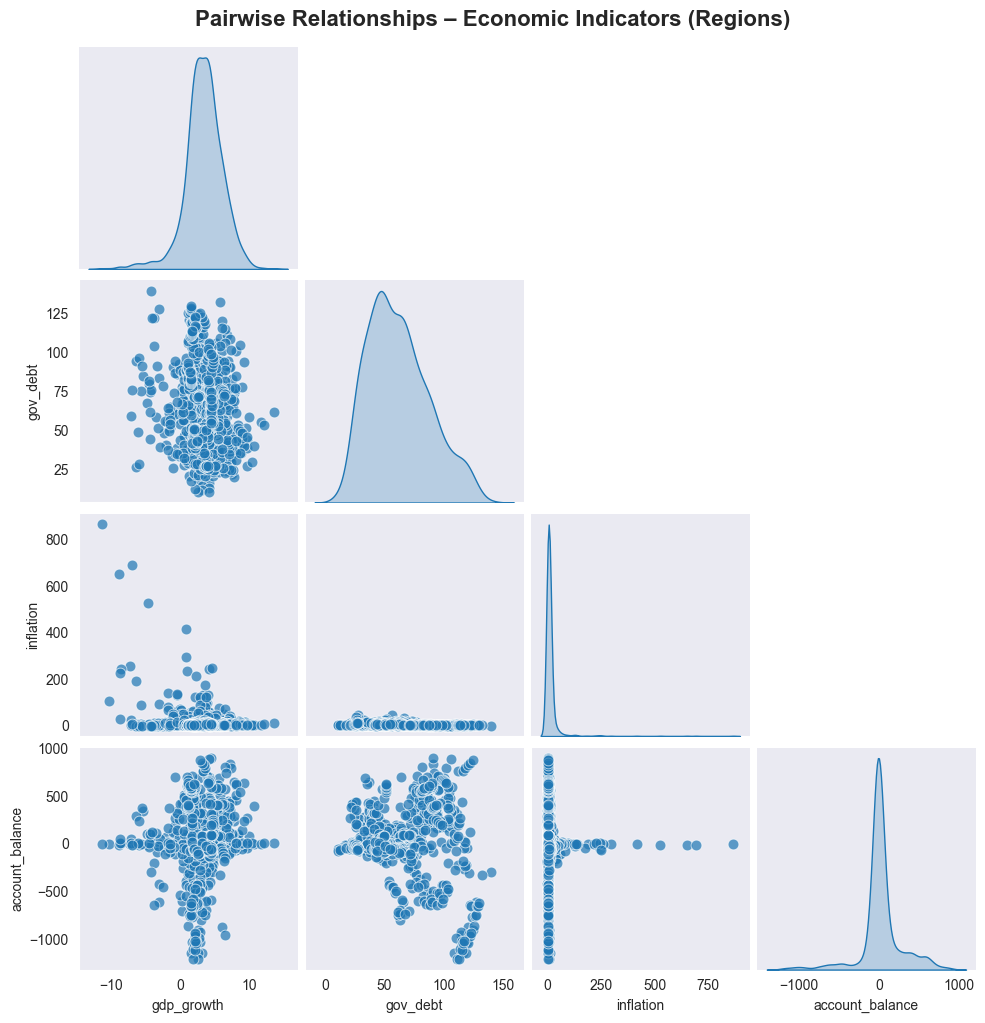

In [68]:
# Only keep numeric columns for the pairplot
region_vars = mega_regions[['gdp_growth', 'gov_debt', 'inflation', 'account_balance']]

sns.pairplot(
    region_vars,
    diag_kind='kde',     # kernel density on the diagonal
    corner=True,         # only show lower triangle
    plot_kws={'alpha': 0.7, 's': 60}  # marker transparency & size
)

plt.suptitle("Pairwise Relationships – Economic Indicators (Regions)", y=1.02, fontsize=16, weight='bold')
plt.show()


## Global Economic Intelligence: Strategic Insights & Future Trajectories

**Synthesis of Regional & Country-Level Patterns**: This comprehensive analysis reveals distinct economic performance clusters globally, with clear leaders emerging in sustainable growth, fiscal discipline, and macroeconomic stability. The correlation patterns demonstrate both the interconnectedness of the global economy and the persistence of regional-specific growth dynamics that create opportunities for strategic positioning and risk diversification.

**Policy Implications & Strategic Framework**: The data suggests that successful economic performance requires balanced approaches across multiple dimensions - growth, inflation control, fiscal responsibility, and external balance management. Countries and regions showing consistent high performance across these metrics provide templates for economic development strategy, while the correlation analysis reveals which policy interventions are likely to have synchronized effects versus independent impact vectors.

**Forward-Looking Economic Intelligence**: Understanding these patterns positions analysts and policymakers to anticipate economic shifts, identify emerging opportunities, and develop resilient strategies for an increasingly complex global economic landscape. The regional correlation insights particularly highlight opportunities for strategic economic partnerships and the importance of geographic diversification in both policy coordination and investment strategies for sustainable long-term economic development.